In [1]:
# ===============================================================
# 🔰 Step 1 — Import Libraries
# ===============================================================
import numpy as np
import pandas as pd
import os, time
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


In [2]:
# ===============================================================
# 🔰 Step 2 — Device Setup & Data Preparation (20:80 Split)
# ===============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ Dataset path
DATA_DIR = "/kaggle/input/dataset-of-plant-parasitic-nematodes/Microscopic Image Dataset of Plant-Parasitic Nematodes"

# ✅ Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ✅ Load dataset using ImageFolder
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)

# ✅ Split 20:80 (Train:Test)
test_ratio = 0.8
test_size = int(test_ratio * len(dataset))
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")

# ✅ Split 10% of Train as Validation
val_ratio = 0.1
val_size = int(val_ratio * len(train_dataset))
train_size_final = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size_final, val_size])
print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

# ✅ Dataloader setup
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Using device: cuda
Train: 204, Test: 812
Train: 184, Validation: 20, Test: 812


In [3]:
# ===============================================================
# 🔰 Step 3 — Model: GoogLeNet
# ===============================================================
from torchvision.models import googlenet, GoogLeNet_Weights

weights = GoogLeNet_Weights.DEFAULT
model = googlenet(weights=weights)
model.aux_logits = False

num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 186MB/s]


In [4]:
# ===============================================================
# 🔰 Step 4 — Train & Evaluate Functions
# ===============================================================
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total


def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    return running_loss / total, correct / total, np.array(all_preds), np.array(all_labels), np.array(all_probs)


In [5]:
# ===============================================================
# 🔰 Step 5 — Training Loop
# ===============================================================
num_epochs = 50
train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_val_acc = 0.0
start_time = time.time()
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _, _ = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_googlenet_model.pth")

end_time = time.time()
train_time = end_time - start_time
print(f"\n✅ Total training time: {train_time:.2f} sec")



Epoch 1/50


Train Loss: 2.3989, Acc: 0.0978 | Val Loss: 2.3145, Acc: 0.1500

Epoch 2/50


Train Loss: 1.9448, Acc: 0.6196 | Val Loss: 2.1251, Acc: 0.3000

Epoch 3/50


Train Loss: 1.6324, Acc: 0.7989 | Val Loss: 1.9456, Acc: 0.3500

Epoch 4/50


Train Loss: 1.3603, Acc: 0.8750 | Val Loss: 1.7838, Acc: 0.4500

Epoch 5/50


Train Loss: 1.1266, Acc: 0.9076 | Val Loss: 1.6613, Acc: 0.5000

Epoch 6/50


Train Loss: 0.9550, Acc: 0.9348 | Val Loss: 1.5601, Acc: 0.5500

Epoch 7/50


Train Loss: 0.7590, Acc: 0.9728 | Val Loss: 1.4791, Acc: 0.5500

Epoch 8/50


Train Loss: 0.6170, Acc: 0.9783 | Val Loss: 1.4256, Acc: 0.5500

Epoch 9/50


Train Loss: 0.5160, Acc: 0.9837 | Val Loss: 1.3592, Acc: 0.6000

Epoch 10/50


Train Loss: 0.4097, Acc: 0.9946 | Val Loss: 1.2811, Acc: 0.6000

Epoch 11/50


Train Loss: 0.3161, Acc: 0.9946 | Val Loss: 1.2350, Acc: 0.6000

Epoch 12/50


Train Loss: 0.2670, Acc: 1.0000 | Val Loss: 1.1873, Acc: 0.6500

Epoch 13/50


Train Loss: 0.2136, Acc: 0.9946 | Val Loss: 1.1428, Acc: 0.7000

Epoch 14/50


Train Loss: 0.1819, Acc: 1.0000 | Val Loss: 1.1153, Acc: 0.7000

Epoch 15/50


Train Loss: 0.1641, Acc: 0.9946 | Val Loss: 1.1072, Acc: 0.6500

Epoch 16/50


Train Loss: 0.1226, Acc: 1.0000 | Val Loss: 1.0726, Acc: 0.6500

Epoch 17/50


Train Loss: 0.1050, Acc: 1.0000 | Val Loss: 1.0338, Acc: 0.6500

Epoch 18/50


Train Loss: 0.0957, Acc: 1.0000 | Val Loss: 1.0016, Acc: 0.6500

Epoch 19/50


Train Loss: 0.0941, Acc: 1.0000 | Val Loss: 0.9801, Acc: 0.6500

Epoch 20/50


Train Loss: 0.0719, Acc: 1.0000 | Val Loss: 0.9721, Acc: 0.6500

Epoch 21/50


Train Loss: 0.0620, Acc: 1.0000 | Val Loss: 0.9601, Acc: 0.7000

Epoch 22/50


Train Loss: 0.0602, Acc: 1.0000 | Val Loss: 0.9586, Acc: 0.6500

Epoch 23/50


Train Loss: 0.0517, Acc: 1.0000 | Val Loss: 0.9497, Acc: 0.6000

Epoch 24/50


Train Loss: 0.0506, Acc: 1.0000 | Val Loss: 0.9433, Acc: 0.6500

Epoch 25/50


Train Loss: 0.0487, Acc: 1.0000 | Val Loss: 0.9275, Acc: 0.6500

Epoch 26/50


Train Loss: 0.0388, Acc: 1.0000 | Val Loss: 0.9037, Acc: 0.6500

Epoch 27/50


Train Loss: 0.0380, Acc: 1.0000 | Val Loss: 0.8895, Acc: 0.6500

Epoch 28/50


Train Loss: 0.0328, Acc: 1.0000 | Val Loss: 0.8937, Acc: 0.6000

Epoch 29/50


Train Loss: 0.0308, Acc: 1.0000 | Val Loss: 0.8929, Acc: 0.6500

Epoch 30/50


Train Loss: 0.0325, Acc: 1.0000 | Val Loss: 0.8976, Acc: 0.6000

Epoch 31/50


Train Loss: 0.0323, Acc: 1.0000 | Val Loss: 0.8876, Acc: 0.6500

Epoch 32/50


Train Loss: 0.0234, Acc: 1.0000 | Val Loss: 0.8886, Acc: 0.6000

Epoch 33/50


Train Loss: 0.0267, Acc: 1.0000 | Val Loss: 0.8744, Acc: 0.6500

Epoch 34/50


Train Loss: 0.0260, Acc: 1.0000 | Val Loss: 0.8750, Acc: 0.6000

Epoch 35/50


Train Loss: 0.0254, Acc: 1.0000 | Val Loss: 0.8609, Acc: 0.6000

Epoch 36/50


Train Loss: 0.0200, Acc: 1.0000 | Val Loss: 0.8544, Acc: 0.6000

Epoch 37/50


Train Loss: 0.0229, Acc: 1.0000 | Val Loss: 0.8479, Acc: 0.6000

Epoch 38/50


Train Loss: 0.0241, Acc: 1.0000 | Val Loss: 0.8260, Acc: 0.7000

Epoch 39/50


Train Loss: 0.0161, Acc: 1.0000 | Val Loss: 0.8107, Acc: 0.7500

Epoch 40/50


Train Loss: 0.0262, Acc: 1.0000 | Val Loss: 0.8099, Acc: 0.7000

Epoch 41/50


Train Loss: 0.0167, Acc: 1.0000 | Val Loss: 0.8317, Acc: 0.7500

Epoch 42/50


Train Loss: 0.0165, Acc: 1.0000 | Val Loss: 0.8433, Acc: 0.7000

Epoch 43/50


Train Loss: 0.0164, Acc: 1.0000 | Val Loss: 0.8410, Acc: 0.7000

Epoch 44/50


Train Loss: 0.0154, Acc: 1.0000 | Val Loss: 0.8344, Acc: 0.7000

Epoch 45/50


Train Loss: 0.0160, Acc: 1.0000 | Val Loss: 0.8327, Acc: 0.7000

Epoch 46/50


Train Loss: 0.0148, Acc: 1.0000 | Val Loss: 0.8245, Acc: 0.7000

Epoch 47/50


Train Loss: 0.0108, Acc: 1.0000 | Val Loss: 0.8278, Acc: 0.6500

Epoch 48/50


Train Loss: 0.0165, Acc: 1.0000 | Val Loss: 0.8270, Acc: 0.6500

Epoch 49/50


Train Loss: 0.0151, Acc: 1.0000 | Val Loss: 0.8280, Acc: 0.6500

Epoch 50/50


Train Loss: 0.0136, Acc: 1.0000 | Val Loss: 0.8412, Acc: 0.6500

✅ Total training time: 220.83 sec


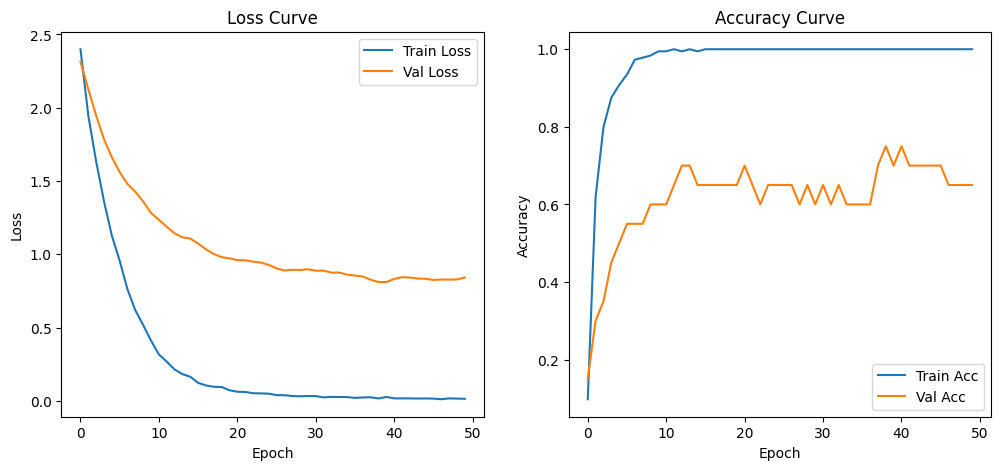

In [6]:
# ===============================================================
# 🔰 Step 6 — Plot Loss & Accuracy Curves
# ===============================================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [7]:
# ===============================================================
# 🔰 Step 7 — Test Evaluation
# ===============================================================
model.load_state_dict(torch.load("best_googlenet_model.pth"))
test_start = time.time()
test_loss, test_acc, all_preds, all_labels, all_probs = evaluate(model, test_loader, criterion)
test_end = time.time()
test_time = test_end - test_start
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"✅ Test time: {test_time:.2f} sec")



✅ Test Accuracy: 57.39%
✅ Test time: 22.09 sec



Classification Report:
                       precision    recall  f1-score   support

      Genus Criconema     0.0000    0.0000    0.0000         4
  Genus Criconemoides     0.6988    0.7632    0.7296        76
Genus Helicotylenchus     0.8061    0.6991    0.7488       113
Genus Hemicycliophora     0.0000    0.0000    0.0000         6
 Genus Hirschmaniella     0.5811    0.3839    0.4624       112
    Genus Hoplolaimus     0.4840    0.8053    0.6047       113
    Genus Meloidogyne     0.5852    0.6095    0.5971       169
   Genus Pratylenchus     0.4151    0.4835    0.4467        91
     Genus Radopholus     0.9000    0.3462    0.5000        26
    Genus Trichodorus     0.5500    0.6875    0.6111        32
      Genus Xiphinema     0.4595    0.2429    0.3178        70

             accuracy                         0.5739       812
            macro avg     0.4982    0.4565    0.4562       812
         weighted avg     0.5835    0.5739    0.5622       812



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


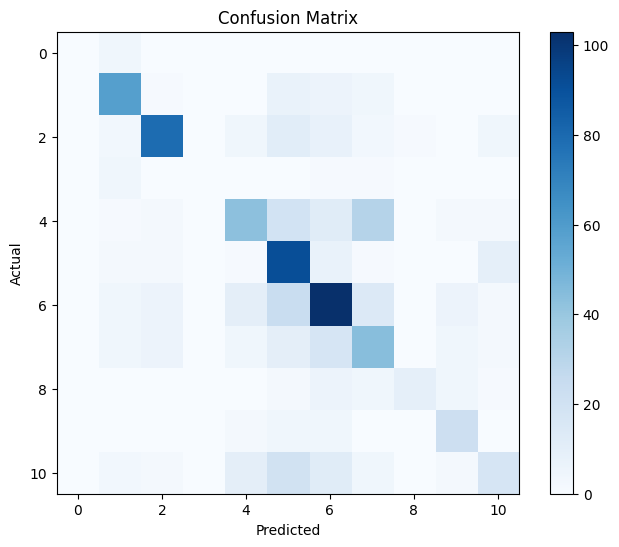


Per-class Accuracy:
Genus Criconema: 0.00%
Genus Criconemoides: 76.32%
Genus Helicotylenchus: 69.91%
Genus Hemicycliophora: 0.00%
Genus Hirschmaniella: 38.39%
Genus Hoplolaimus: 80.53%
Genus Meloidogyne: 60.95%
Genus Pratylenchus: 48.35%
Genus Radopholus: 34.62%
Genus Trichodorus: 68.75%
Genus Xiphinema: 24.29%


In [8]:
# ===============================================================
# 🔰 Step 8 — Classification Report & Confusion Matrix
# ===============================================================
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

unique_labels = sorted(list(set(all_labels)))
target_names = [dataset.classes[i] for i in unique_labels]

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, labels=unique_labels, target_names=target_names, digits=4))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.show()

per_class_acc = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class Accuracy:")
for i, label_idx in enumerate(unique_labels):
    cls_name = dataset.classes[label_idx]
    print(f"{cls_name}: {per_class_acc[i]*100:.2f}%")


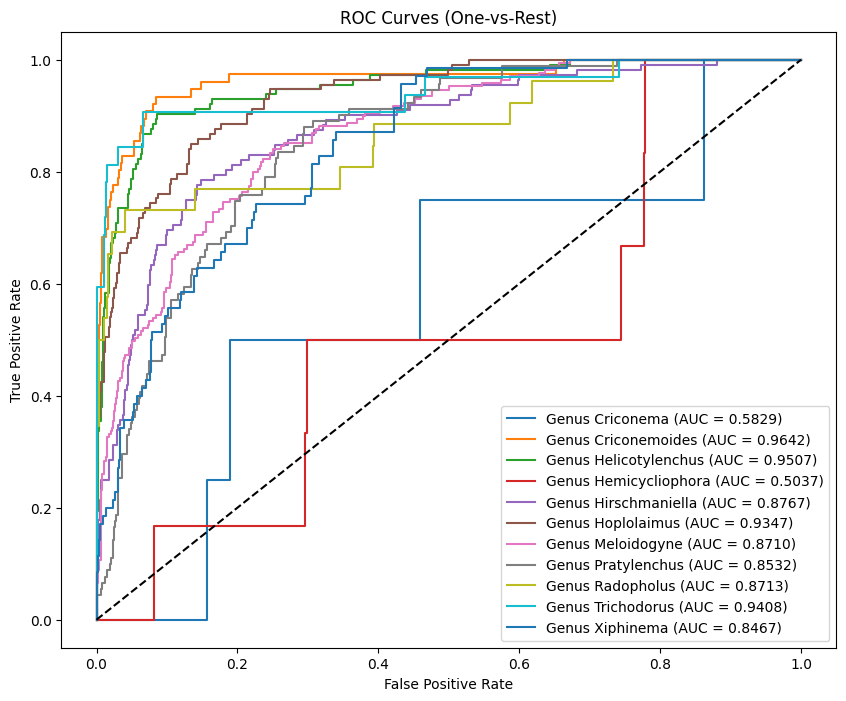

In [9]:
# ===============================================================
# 🔰 Step 9 — ROC-AUC per class
# ===============================================================
plt.figure(figsize=(10,8))
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

for i, cls in enumerate(dataset.classes):
    binary_labels = (all_labels == i).astype(int)
    fpr, tpr, _ = roc_curve(binary_labels, all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{cls} (AUC = {roc_auc:.4f})')

plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curves (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [10]:
# ===============================================================
# 🔰 Step 10 — Full Metrics Evaluation
# ===============================================================
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

all_labels = np.array(all_labels)
all_preds  = np.array(all_preds)

accuracy  = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall    = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1        = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print("✅ Full Model Metrics on Test Set:")
print(f"Accuracy : {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall   : {recall*100:.2f}%")
print(f"F1-Score : {f1*100:.2f}%")


✅ Full Model Metrics on Test Set:
Accuracy : 57.39%
Precision: 58.35%
Recall   : 57.39%
F1-Score : 56.22%
